# Ozone simulation

ATSC 595

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit

from IPython.display import clear_output

In [2]:
##################################################################
# initialize each species
initconcs = {
    "CO": 2.5e12,  # molecules / cm^3
    "HO2": 0.0,  # molecules / cm^3
    "NO": 1.25e12,  # molecules / cm^3
    "NO2": 1.25e11,  # molecules / cm^3
    "O1D": 0.0,  # molecules / cm^3
    "O3": 0.0,  # molecules / cm^3
    "OH": 0.0,  # molecules / cm^3
    # "H2O":2.5e15    # molecules / cm^3  which is 0.01% of the air at sea level
}

##################################################################
# initialize rate constants (treat H2O conc as a constant)
j01 = (1.0e-3,)  # (units 1/s) for {01'}  NO2 + h·nu -> NO + O3
k03 = (1.73e-15,)  # (units (s · molecules/cm^3)^-1 ) for {03}   O3 + NO -> (O2) + NO2
j09 = (1.0e-6,)  # (units 1/s) for {09}   O3 + h·nu -> (O2) + O1D
k11 = 2.14e-10  # (units (s · molecules/cm^3)^-1 ) for {11} O1D + H2O -> 2 OH
k25 = (8.54e-12,)  # (units (s · molecules/cm^3)^-1 ) for {25} HO2 + NO -> OH + NO2
k123 = (2.28e-14,)  # units (s · molecules/cm^3)^-1 for {123} OH +CO +(O2)-> HO2 + (CO2)
H2O = 2.5e15  # molecules / cm^3  which is 0.01% of the air at sea level

####################################################################
# Time step info
delt_s = 0.0001  # time step (s) for your iterations
tend_h = 2.0  # duration of forecast (hours)
tsave_m = 2.0  # how often (minutes) to save results to plot

# convert everything to seconds
tend = tend_h * 3600
tsave = tsave_m * 60
delt = delt_s

# tiny sim for testing code
#tend = 1
#tsave = 0.1
#delt = 0.0001

In [3]:
@jit
def init(c0, tend, tsave):
    """
    concs:
        initializes a dataframe with columns for each chemical species,
        sets the first row to the specified initial concentrations c0
        
    initconcs:
        creates a 1-row dataframe to pass to loop fcn, same cols as concs
    """
    time = np.arange(0, tend, tsave) # timesteps to save
    
    # create the master dataframe
    tseries = pd.DataFrame(columns=c0.keys(), index=time)
    
    # create mini dataframe to pass into loop
    initconcs = pd.DataFrame(columns=c0.keys(), index=["Concentration"])
    
    # fill first row with initial concentrations
    concs = np.fromiter(c0.values(), dtype=float)
    tseries.loc[time[0]] = concs
    initconcs.iloc[0] = concs
    
    return tseries, initconcs

In [4]:
@jit
def step_fwd(c_old, delt):
    """
    this function holds all of the combined prod/loss equations


    """
    c_new = c_old

    c_new["CO"] += -(k123 * c_old["OH"] * c_old["CO"]) * delt
    c_new["HO2"] += (
        k123 * c_old["OH"] * c_old["CO"] - k25 * c_old["HO2"] * c_old["NO2"]
    ) * delt
    c_new["NO"] += (
        (j01 * c_old["NO2"])
        - (k03 * c_old["O3"] * c_old["NO"])
        - (k25 * c_old["HO2"] * c_old["NO2"])
    ) * delt
    c_new["NO2"] += (
        -(j01 * c_old["NO2"])
        + (k03 * c_old["O3"] * c_old["NO"])
        + (k25 * c_old["HO2"] * c_old["NO2"])
    ) * delt
    c_new["O1D"] += ((j09 * c_old["O3"]) - (k11 * c_old["O1D"] * H2O)) * delt
    c_new["O3"] += (
        (j01 * c_old["NO2"]) - (k03 * c_old["O3"] * c_old["NO"]) - (j09 * c_old["O3"])
    ) * delt
    c_new["OH"] += (
        ((2 * k11 * H2O) * c_old["O1D"])
        + (k25 * c_old["HO2"] * c_old["NO2"])
        - (k123 * c_old["OH"] * c_old["CO"])
    )

    # take all negative concentrations to zero
    c_new[c_new < 0] = 0

    return c_new

In [5]:
# toy simulation
save_concs, concs = init(initconcs, tend, tsave)

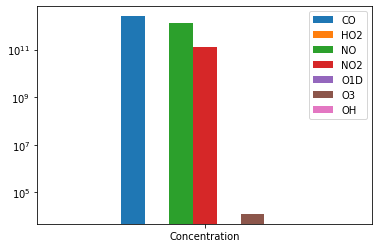

In [6]:
# execute this cell as many times as you like to manually step the simulation forward
step_fwd(concs, delt)
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xticks(ticks=[])
concs.plot(kind="bar", ax=ax);

In [9]:
# full simulation (as spec'd by time step info in cell 1)
@jit
def do_sim(initconcs, tend, delt, tsave):
    """
    runs simulation
    """
    tseries, concs = init(initconcs, tend, tsave)
    for T in tseries.index[1:]:
        clear_output()
        print(f"Simulating: {round(T / tend * 100, 3)}%")
        for t in np.arange(0, tsave, delt):
            concs = step_fwd(concs, delt)
        #print(f"concs at {T} seconds: {concs.values[0]}")
        tseries.loc[T] = concs.values[0]
    clear_output()
    print("Simulation complete")
    return tseries


In [10]:
tseries = do_sim(initconcs, tend, delt, tsave)
# show the result:
tseries

Simulation complete


,CO,HO2,NO,NO2,O1D,O3,OH
0.0,2500000000000.0,0.0,1250000000000.0,125000000000.0,0.0,0.0,0.0
0.1,2499999999998.101562,1.83429,1250012498025.547852,124987501974.452896,0.001249,12498023.738846,1337.909372
0.2,2499999999992.379395,7.107631,1250024992098.783203,124975007901.218842,0.002498,24992094.298719,2680.403314
0.3,2499999999982.82666,15.480233,1250037482220.552246,124962517779.449615,0.003747,37482212.875962,4025.780739
0.4,2499999999969.4375,26.645861,1250049968391.738525,124950031608.26384,0.004996,49968380.666626,5373.714009
0.5,2499999999952.204102,40.328525,1250062450613.253906,124937549386.749008,0.006244,62450598.866464,6723.907885
0.6,2499999999931.117676,56.279487,1250074928886.038818,124925071113.964722,0.007492,74928868.670929,8076.096323
0.7,2499999999906.175293,74.274569,1250087403211.054443,124912596788.945847,0.008739,87403191.275172,9430.039587
0.8,2499999999877.373047,94.111726,1250099873589.296631,124900126410.704636,0.009986,99873567.874038,10785.521641
0.9,2499999999844.705566,115.608861,1250112340021.768555,124887659978.233078,0.011233,112339999.662064,12142.347812
